# Electrophysiology preprocessing
This notebook will explore the basic pipeline for processing and analyzing neural data recorded using the Intan system.

## Initial setup

### Imports

In [1]:
# Numerical tools
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# General purpose
import os, re, glob, sys
import struct
import h5py
import getpass
from time import time
import json

# MountainSort, etc.
from mountainlab_pytools import mdaio
from mountainlab_pytools import mlproc as mlp
from ml_ephys.preprocessing.p_bandpass_filter import bandpass_filter as ml_bandpass_filter
from ml_ephys.preprocessing.p_whiten import whiten as ml_whiten
from ml_ms4alg.p_ms4alg import sort as ml_sort

# Ephys code
sys.path.insert(0, '../python/')
import util
import ephys

### Settings

In [2]:
# Raw ephys data
#raw_dir = 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928/'
raw_dir = '/media/james/mcginley_server_3/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928/'

# Preprocessed ephys data (Google Drive API)
pre_dir = '/media/james/data/foraging/ephys/02-04-19/spike_sorting/mountainsort/shank_2/' # preprocessed data directory

# Output
results_dir = '/media/james/data/foraging/ephys/02-04-19/analysis/shank_2/' # directory to store downloads

# Channels
channel_ids = []
channel_ids.append(np.arange(64, dtype=np.int16))
channel_ids.append(np.arange(64, 128, dtype=np.int16))
shank_id = 0 # shank to analyze (0-indexed!)

# Spike sorting parameters
rv_thresh = 1.0 # threshold for refractory violation period

# Autocorrelogram
dt_bin = 0.001
dt_bin_max = 0.100

# Waveform
dt_wf = 0.005 # window size (s)
fs = 30000 # sampling rate

In [28]:
# Allow read/write permissions from directory
password = getpass.getpass()
command = 'sudo -S chmod 777 %s && sudo -S chmod 777 %s' % (pre_dir, results_dir) # -S enables input from stdin
os.system('echo %s | %s' % (password, command));

········


0

### Get raw data

In [29]:
# Placeholders
raw_files = []
ch_ids = []

# Find raw files and associated channel IDs
regexp = re.compile(r'amp-A-[0-9]+')
for f in os.listdir(raw_dir):
    if regexp.search(f):
        raw_files.append(f)
        ch_ids.append(int(f[6:9]))

# Sort if necessary
ch_ids = np.asarray(ch_ids)
sort_idx = np.argsort(ch_ids)
ch_ids = ch_ids[sort_idx]
raw_files = [raw_files[i] for i in sort_idx]

In [30]:
# Find all raw data files
#raw_files = sorted(glob.glob(raw_dir + 'amp*.dat'))
#ch_ids = np.array([int(f[6:9]) for f in raw_files])

# Keep only channels to analyze
channels = [i for i in ch_ids if i in channel_ids[shank_id]]
raw_files = [raw_files[i] for i in channels]
ch_ids = channels

In [31]:
# Load data in numpy array
X = []
for i in range(len(raw_files)):
    print('Processing file %02d of %02d...' % (i+1, len(raw_files)))
    X.append(np.fromfile(raw_dir + raw_files[i], dtype=np.int16))
    
X = np.array(X)
print(X.shape)
print('total recording time: %.2f min' % (X.shape[1]/fs/60))

Processing file 01 of 64...
Processing file 02 of 64...
Processing file 03 of 64...
Processing file 04 of 64...
Processing file 05 of 64...
Processing file 06 of 64...
Processing file 07 of 64...
Processing file 08 of 64...
Processing file 09 of 64...
Processing file 10 of 64...
Processing file 11 of 64...
Processing file 12 of 64...
Processing file 13 of 64...
Processing file 14 of 64...
Processing file 15 of 64...
Processing file 16 of 64...
Processing file 17 of 64...
Processing file 18 of 64...
Processing file 19 of 64...
Processing file 20 of 64...
Processing file 21 of 64...
Processing file 22 of 64...
Processing file 23 of 64...
Processing file 24 of 64...
Processing file 25 of 64...
Processing file 26 of 64...
Processing file 27 of 64...
Processing file 28 of 64...
Processing file 29 of 64...
Processing file 30 of 64...
Processing file 31 of 64...
Processing file 32 of 64...
Processing file 33 of 64...
Processing file 34 of 64...
Processing file 35 of 64...
Processing file 36 o

In [32]:
# Save data in directory
if not os.path.isdir(pre_dir + 'original/'):
    os.mkdir(pre_dir + 'original/')
mdaio.writemda16i(X, pre_dir + 'original/raw.mda')

True

## Spike sorting
### MountainSort
Once the initial `.mda` file is converted from the raw `.dat` files, spikes can be extracted and sorted using `MountainSort`. The final product will be another `.mda` file that contains the firing data. Full documentation [here](https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md).

The basic process requires four steps:
1. **Bandpass filter**: typically between 600 Hz and 6000 Hz.
2. **Whiten data spatially**: breaks noise correlations between channels.
3. **Sort waveforms**.
4. **Compute cluster metrics**: isolation, noise_overlap, firing_rate, snr_peak.
5. **Semi-auto curation**: based on cluster metrics.

#### Data preprocessing, spike detection, and sorting algorithm
The associated steps in the command-line interface are (with recommended parameters):

```
ml-run-process ephys.bandpass_filter --inputs timeseries:<raw_filename>.mda  --outputs timeseries_out:<raw_filename>_bandpass.mda --parameters samplerate:30000 freq_min:<freq_min> freq_max:<freq_max>

ml-run-process ephys.whiten --inputs timeseries:<raw_filename>_bandpass.mda  --outputs timeseries_out:<raw_filename>_whitened.mda

ml-run-process ms4alg.sort --inputs timeseries:<raw_filename>_whitened.mda geom:<geom_filename>.csv --outputs firings_out:<firings_filename>.mda --parameters adjacency_radius:-1 detect_sign:-1 detect_threshold:4
```

Some notes about the above processes:
- Docstrings for the functions called by the processor can be found in the [appendix](#Appendix).
- To run sequentially, simply add `&&\` after each line in terminal.
- To use the geometry of the electrode configuration on the shank for spike sorting, we must first create a `.csv` file containing a list of coordinates for each electrode, such that each row is [channel_id, x, y, z].
- Code for the processes can be found on github: [ephys](https://github.com/magland/ml_ephys), [ms4alg](https://github.com/magland/ml_ms4alg/tree/master/ml_ms4alg), [pipeline](https://github.com/magland/ml_ms4alg/blob/master/examples/ms4alg_pipelines.py)

After running the above processes, the following files should have been created:
- `<raw_filename>_bandpass.mda`: bandpass-filtered raw data [M channels x T samples]
- `<raw_filename>_whitened.mda`: whitened, bandpass-filtered raw data [M channels x T samples]
- `<firings_filename>.mda`: a [3 x N] array containing firing data with the following rows
    - `channel_id`: the channel number associated with the spike
    - `t_spike`: the sample number associated with the spike
    - `cluster_id`: the unit number associated with the spike
- `combined_metrics.json`: cluster metrics for every sorted unit

#### Unit curation 
Although initially implied to be fully automated, the best practice is still to combine automated features with manual inspection. The workflow is as follows. First, compute the cluster metrics useful for curation (requires installing the `ml_ms3` module):

```
ml-run-process ms3.cluster_metrics --inputs firings:<firings_filename>.mda timeseries:<raw_filename>_whitened.mda --outputs cluster_metrics_out:cluster_metrics.json --parameters samplerate:30000

ml-run-process ms3.isolation_metrics --inputs firings:<firings_filename>.mda timeseries:<raw_filename>_whitened.mda --outputs metrics_out:isolation_metrics.json pair_metrics_out:pair_metrics.json --parameters compute_bursting_parents:true

ml-run-process ephys.compute_cluster_metrics --inputs firings:<firings_filename>.mda timeseries:<raw_filename>_whitened.mda --outputs metrics_out:cluster_metrics_ms4.json --parameters samplerate:30000 clip_size:100 refrac_msec:1.0

ml-run-process ms3.combine_cluster_metrics --inputs metrics_list:cluster_metrics_ms3.json metrics_list:cluster_metrics_ms4.json metrics_list:isolation_metrics.json --outputs metrics_out:metrics.json
```

A quick note about `ephys.combine_cluster_metrics`. Unlike the other two metrics processes, this one does not filter out clusters that are no longer being analyzed (either through rejecting or merging). Instead, it assumes all clusters exist with labels $[1, ..., K]$, where $K$ is the largest label integer. Clusters that have disappeared with labels in that range will still be analyzed with sometimes uninterpretable metrics or metrics that are incompatible with JSON files (e.g. writing NaN). This will cause the last step (`ms3.combine_cluster_metrics`) to simply ignore that JSON file as input (but without raising any warning or error!). To correct for this issue, simply add the following line of code to the `p_compute_cluster_metrics.py` script in the `ml_ephys` module:

```
clusters = [cluster for cluster in clusters if cluster['metrics']['num_events'] > 0.0]
```

In the completely automated method, the next steps would be to run the `ms4alg.create_label_map` and `ms4alg.apply_label_map` processes from the command-line interface, which would ultimately create a `curated_firings.mda` file that removes and merges units from `firings.mda` based on cluster metrics. There are two issues with this. First, the cluster metrics, while useful, still do not entirely capture the complexity of clusters (e.g. drifting, etc.). Second, when cluster metrics are recomputed in the next pass of curation, they should still include the rejected units, which have been removed in the `curated_firings.mda` file (note, however, that the original `firings.mda` file won't work either, since it doesn't include merged units). To account for these issues, instead run the process `pyms.add_curation_tags` from the Frank lab package. This will tag units that do not meet the cluster metric criteria with `mua`. Next, run `qt-mountainview` and apply own tags, looking for merges, multi-unit activity, drifts, etc. Once the initial pass is complete, run the process `pyms.merge_burst_parents` to merge units with bursting parents. In summary:

```
ml-run-process pyms.add_curation_tags --inputs metrics:metrics.json --outputs metrics_tagged:metrics.json  --parameters firing_rate_thresh:0.1 isolation_thresh:0.95 noise_overlap_thresh:0.03 peak_snr_thresh:1.5

qt-mountainview

ml-run-process pyms.merge_burst_parents
```

Now cluster metrics can once again be calculated, and the process is repeated until no additional changes are made.

#### Automated sorting and curation
Rather than having to run all steps in the command-line interface (and monitor for the progress of each process), we can use `ephys.sort_spikes(timeseries)` from my `ephys` module instead. This script automatically runs the above processes in order (filter, whiten, sort, calculate metrics, apply tags) with parameters specified in one of two ways: either in a JSON file (`config=filename`) or as individual keyword arguments (`**kwargs`). In either case, parameters not specified will be assigned the default values below:
```
'output_dir': './',
'geom_filepath': '',
'sample_rate': 30000,
'freq_min': 300,
'freq_max': 6000,
'adjacency_radius': -1,
'detect_sign': -1,
'detect_threshold': 4,
'bursting_parents': True,
'clip_size': 100,
'refrac_msec': 1.0,
'firing_rate_thresh': 0.1,
'isolation_thresh': 0.95,
'noise_overlap_thresh': 0.03,
'peak_snr_thresh': 1.5,
'opts': {}
```

The names and values of these parameters are exactly the same as appears in the command-line interface. Note that the only exceptions are that initial inputs must be provided for a couple of processes (all other I/O is piped automatically):
- `output_dir`: The output directory in which to store output files from all processes.
- `geom_filepath`: The full filepath to the geometry `.csv` file needed for the sorting algorithm.

Note that the location of the `ml-run-process` executable must be in the environment `$PATH` variable. If installed in a `conda` environment, for example, then jupyter must be started with that environment activated; otherwise, `$PATH` will not correspond that the `conda` environment. In other words, if using the environment `ms4js`, then simply run the following to start this notebook:

```
source activate ms4js
jupyter notebook
```

#### MountainView
Start MountainView by running from the command-line with `qt-mountainview`. Unfortunately, this is about as far as the documentation goes (from what I can find), so let's write out the rest here. The command-line interface takes *named parameters* of the form `--<param_name>=<value>` and *unnamed parameters* as simply `<value>` (see [here](https://github.com/flatironinstitute/qt-mountainview/blob/master/cpp/mountainview/src/mountainviewmain.cpp#L237) and [here](https://github.com/flatironinstitute/qt-mountainview/blob/master/packages/mv/common/clparams.cpp) for code details). These are as follows:

```
unnamed parameters:
  <filename>.mv
  <filename>.mv2: cluster tags
  <filename>.smv: MountainView configuration file
  unit_test: possible values are remotereadmda, remotereadmda2, taskprogressview

named parameters:
--mode: possible values are overview2, spikespy
--timeseries: (whitened) timeseries file (overview2, spikespy modes)
--firings: firings mda file (overview2, spikespy modes)
--samplerate: sample rate (Hz) (overview2, spikespy modes)
--filt: filtered data (overview2 mode)
--pre: preprocessed data (overview2 mode)
--mlproxy_url (overview2 mode)
--window_title (overview2 mode)
--geom: csv file containing geometry of channels on probe (overview2 mode)
--cluster_metrics: JSON file containing cluster metrics (overview2 mode)
--curation: path to curation program (overview2 mode)
--clusters: subset of clusters to view (overview2 mode); set as comma-separated list of ints (e.g. 1,5,8)
```

If following the above procedure, then a suggested command is:

```
qt-mountainview --timeseries=<raw_filename>_whitened.mda --firings=<firings_filename>.mda --samplerate:30000 --geom=<geometry_filename>.csv --cluster_metrics=combined_cluster_metrics.json
```

Random notes:
- How are cluster pairs selected for comparison? First, the waveform template for each cluster is compared to that of every other cluster by obtaining the squared distance (i.e. $||\mathbf{X}-\mathbf{Y}||^2$) and correlation between them. The three clusters with the lowest squared distances (i.e. most similar) and correlation scores >0.8 are added to the list of pair comparisons to perform. Then, for each pair in the list, the overlap in PC space is computed (which uses a k-nearest-neighbors search; see paper for details). The `overlap_cluster` metric computed in `ms3.isolation_metric` corresponds to the cluster with the highest overlap score.
- When looking at waveforms, MountainView displays templates in *channel number* order (with channel 1 at the top), even if a `geom` file is provided! Thus channels close together on the physical probe may be displayed far apart, meaning that the largest waveforms for a particular cluster could be separated by many channels on the display. Also, when inspecting geometry, keep in mind 0- vs. 1-based indexing.
    - 0-indexed: wiring diagram, my timeseries_reader code
    - 1-indexed: sorted output (`firings.mda1`), MountainView

In [ ]:
# Move above documentation to new repo in separate md file
# Then move notebook and associated python scripts into same repo
# Do spike sorting out of notebook; see how to run processes at https://github.com/magland/mountainlab_pytools/blob/master/test/test.ipynb
# or better yet, create pipeline script like ms4_sort_dataset that pulls from mlproc

In [14]:
# Settings
timeseries_filepath = pre_dir + 'original/raw.mda'
config_filepath = '../config/sort.json'

# Initialize pipeline
Pipeline = mlp.initPipeline()

# Run sorting script
with Pipeline:
    client = Pipeline._client
    ephys.sort_spikes(timeseries=timeseries_filepath, config=config_filepath)
    
#ephys.track_pipeline_progress(client)

/home/james/anaconda3/envs/ms4js/lib/python3.6/site-packages/jp_proxy_widget/proxy_widget.py:181: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  self.on_trait_change(self.handle_rendered, "rendered")
/home/james/anaconda3/envs/ms4js/lib/python3.6/site-packages/jp_proxy_widget/proxy_widget.py:182: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  self.on_trait_change(self.handle_error_msg, "error_msg")


JSProxyWidget(status='Not yet rendered')

Loading parameters... done.


Output()

/home/james/anaconda3/envs/ms4js/lib/python3.6/site-packages/mountainlab_pytools/mlproc/mlclient.py:129: ResourceWarning: unclosed file <_io.BufferedReader name=52>
  self.check_running_job(job)


Finished pipeline.


#### Edit curation files
After running the above script or using the command-line interface for MountainSort, and tagging clusters in MountainView, run the following to create `firings_curated.mda`, which contains spiking information of only clusters that have passed both automated (cluster metrics) and manual (MountainView) inspection.

In [17]:
# Settings
firings_old_filepath = pre_dir + 'original/firings.mda' # firings before this curation iteration
firings_merged_filepath = pre_dir + 'curation_1/firings_merged.mda' # merged firings from MountainView
firings_curated_filepath = pre_dir + 'curation_1/firings_curated.mda' # location to store curated firings
metrics_filepath = pre_dir + 'curation_1/metrics_curated.json' # metrics file with all tags

In [18]:
# Create map of merges during curation
ephys.create_merge_map(firings_old=firings_old_filepath, 
                       firings_new=firings_merged_filepath,
                       merge_map_out=pre_dir + 'curation_1/merge_map.json');

In [36]:
# Update new cluster metrics with tags added during curation
#metrics_tagged_filepath = pre_dir + 'curation_1/metrics_curated_tagged.json'
#ephys.update_cluster_tags(metrics_old=cluster_metrics_old_filepath,
#                          metrics_new=cluster_metrics,
#                          metrics_out=metrics_tagged_filepath);

In [20]:
# Create firings file of only accepted clusters for analysis
ephys.curate_firings(firings=firings_merged_filepath,
                     metrics=metrics_filepath,
                     keep_tags='accepted',
                     firings_out=firings_curated_filepath);

### Manual inspection
After automatically and manually curating the sorted clusters with MountainSort and MountainView, respectively, use this section to inspect the final results with tools such as autocorrelograms, waveform templates, etc.

#### Settings

In [25]:
timeseries_filepath = pre_dir + 'original/raw_whitened.mda'
firings_filepath = pre_dir + 'curation_1/firings_curated.mda'
metrics_filepath = pre_dir + 'curation_1/metrics_curated.json'
geom_filepath = pre_dir + '../ml_files/geom128-s1.csv'
use_google_drive = False # if true, find files in Google Drive
storage_mode = 1 # 0 = read from server, 1 = download to/read from local disk, 2 = load in memory

#### Load files

In [23]:
# Load data
if use_google_drive:
    # Create Service object
    drive_service = util.GoogleDriveService()
    
    # Load spike data
    print('Loading spike data...', end=' ')
    firings = util.bytes_to_object(drive_service.download(filename=firings_filepath), ob_type='numpy')
    print('done.')
    
    # Load File object for reading timeseries MDA file
    print('Creating File object for timeseries MDA file...', end=' ')
    if storage_mode == 0:
        # To save storage, can continually read from server, but this can be prohibitively slow
        # if many reads are required
        drive_file = util.GoogleDriveFile(drive_service, timeseries_filepath)
        timeseries_reader = util.MDAReader(drive_file)
    elif storage_mode == 1:
        # Faster to download entire file and store on hard disk, but files can be large (~50+ GB)
        if not os.path.exists(media_dir + timeseries_filepath):
            f = open(media_dir + timeseries_filepath, 'w+b')
            drive_service.download(filename=timeseries_filepath, file_object=f)
            f.seek(0, 0) # reset pointer to beginning of file
        else:
            f = open(media_dir + timeseries_filepath, 'rb')
        timeseries_reader = util.MDAReader(f)
    elif storage_mode == 2:
        # Fastest to load entirely in memory
        f = io.BytesIO(drive_service.download(filename=timeseries_filepath))
        timeseries_reader = util.MDAReader(f)
    else:
        raise SyntaxError('Unknown storage mode %d.' % storage_mode)
    print('done.')
        
    # Load cluster metrics
    cluster_metrics = util.bytes_to_object(drive_service.download(filename=metrics_filepath), ob_type='json')
    
else:
    # Load spike data
    with open(firings_filepath, 'rb') as f:
        firings = util.MDAReader(f).read()
    
    # Load File object for reading timeseries MDA file
    if storage_mode in [0, 1]:
        timeseries_reader = util.MDAReader(open(timeseries_filepath, 'rb'))
    elif storage_mode == 2:
        timeseries_reader = io.BytesIO(open(timeseries_filepath, 'rb'))
        
    # Load cluster metrics
    with open(metrics_filepath, 'r') as f:
        cluster_metrics = json.loads(f.read())

/home/james/anaconda3/envs/ms4js/lib/python3.6/site-packages/ipykernel_launcher.py:45: ResourceWarning: unclosed file <_io.BufferedReader name='/media/james/data/foraging/ephys/02-04-19/spike_sorting/mountainsort/shank_2/original/raw_whitened.mda'>


#### Autocorrelogram

In [ ]:
# Compute autocorrelogram
isi = [] # inter-spike intervals
for i, unit in enumerate(cluster_ids):
    print('Processing unit %d (%d of %d)...' % (unit, i+1, len(cluster_ids)), end=' ')
    
    # Get spike times during behavior
    t_spikes_ = t_spikes[spikes[2, :] == unit]
    t_spikes_ = t_spikes_[t_spikes_ > 0]
    num_spikes = len(t_spikes_)

    # Placeholders
    idx = np.arange(num_spikes) # indices to compute ISI
    j = 1 # number of spikes ahead to compute ISI
    isi_ = [] # inter-spike intervals for unit
    while True:
        # Filter indices by max ISI for given step size
        idx = idx[idx + j < num_spikes] # handle end case
        idx = idx[t_spikes_[idx + j] - t_spikes_[idx] <= dt_bin_max] # limit max ISI

        # Compute ISI for given step size
        if idx.size > 0:
            isi_j = t_spikes_[idx + j] - t_spikes_[idx]
            isi_.append(isi_j)
            isi_.append(-isi_j)
            j += 1
            # No need to reset idx, since j has at least as many as j+1
        else:
            break
    
    # Save flattened list of ISIs
    isi.append(flatten_list(isi_))
    
    print('done.')

In [ ]:
# Plot settings
cols = 4
rows = (num_units // cols) + (num_units % cols)
dt_refrac = 0.001 # refractory period (s)
num_bins = dt_bin_max // dt_bin
bin_edges = np.arange(-num_bins, num_bins+1) * dt_bin

fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))

for i, unit in enumerate(cluster_ids):
    print('Processing unit %d (%d of %d)...' % (unit, i+1, len(cluster_ids)), end=' ')
    
    # Set axis indices
    j = i // cols
    k = i % cols
    
    # Plot histogram and outline refractory period
    hist, _, _ = ax[j, k].hist(isi[i], bins=bin_edges)
    _ = ax[j, k].fill_between(np.array([-dt_refrac, dt_refrac]), y1=0.0, y2=np.max(hist),
                              alpha=0.2, color='black')
    
    # Axis settings
    ax[j, k].set_title('unit %d' % unit)
    ax[j, k].set_xlabel('ISI (s)')
    ax[j, k].set_ylabel('count')
    
    print('done.')

# Plot settings
plt.tight_layout();

#### Templates

In [26]:
geom = np.loadtxt(geom_filepath)

In [27]:
cluster_labels, wfs = ephys.get_templates(timeseries=timeseries_reader,
                                          firings=firings,
                                          templates_out=pre_dir + 'curation_1/templates_curated.npy',
                                          window=[-2.5, 2.5],
                                          f_s=30000,
                                          scale=0.195)

Processing unit 28 (1 of 25)... done. (6.625 seconds)
Processing unit 30 (2 of 25)... done. (10.751 seconds)
Processing unit 32 (3 of 25)... done. (29.109 seconds)
Processing unit 35 (4 of 25)... done. (11.172 seconds)
Processing unit 37 (5 of 25)... done. (4.145 seconds)
Processing unit 38 (6 of 25)... done. (3.413 seconds)
Processing unit 40 (7 of 25)... done. (5.271 seconds)
Processing unit 44 (8 of 25)... done. (5.909 seconds)
Processing unit 45 (9 of 25)... done. (2.619 seconds)
Processing unit 47 (10 of 25)... done. (0.776 seconds)
Processing unit 49 (11 of 25)... done. (0.214 seconds)
Processing unit 89 (12 of 25)... done. (9.150 seconds)
Processing unit 90 (13 of 25)... done. (1.300 seconds)
Processing unit 91 (14 of 25)... done. (4.499 seconds)
Processing unit 97 (15 of 25)... done. (1.416 seconds)
Processing unit 100 (16 of 25)... done. (0.969 seconds)
Processing unit 101 (17 of 25)... done. (5.060 seconds)
Processing unit 104 (18 of 25)... done. (1.987 seconds)
Processing un

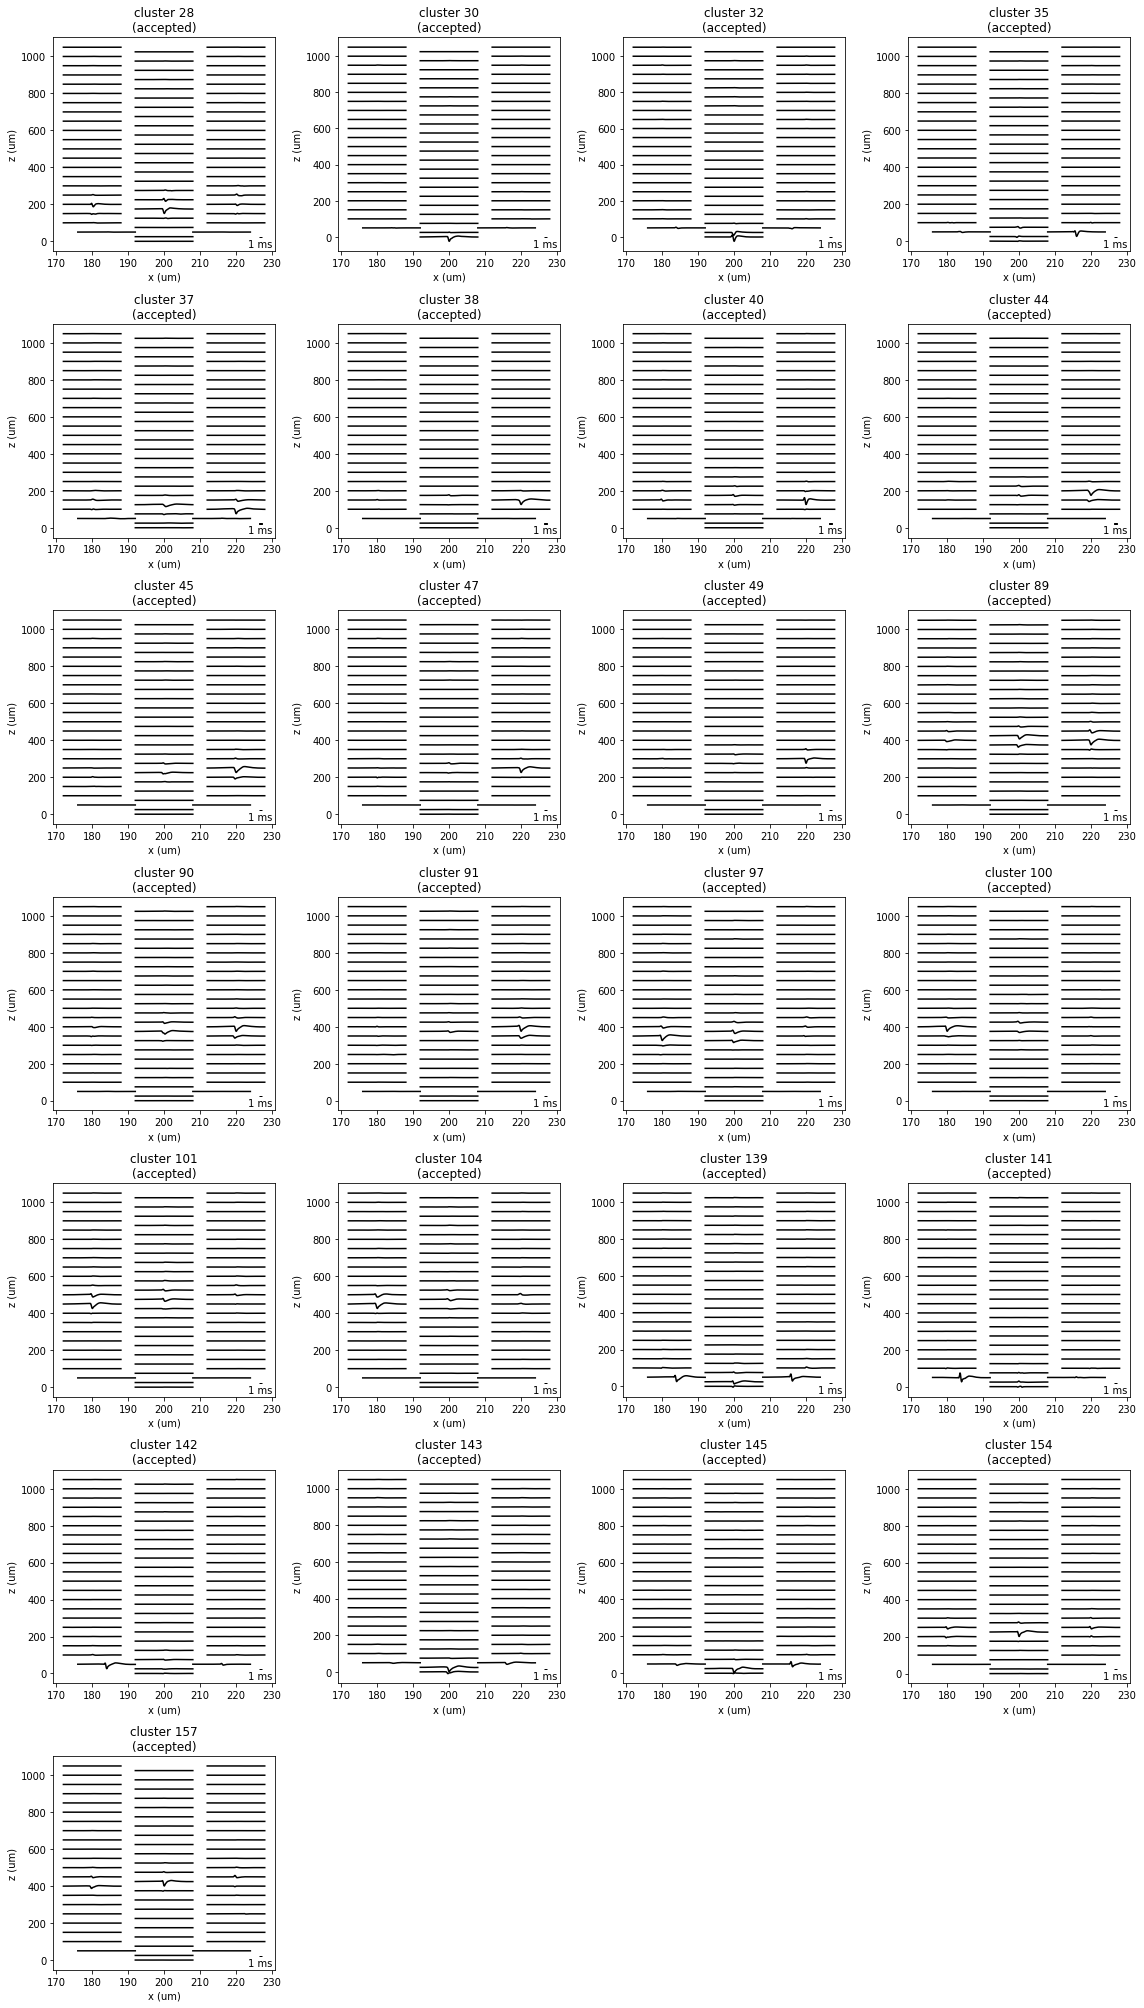

In [28]:
ephys.plot_templates(labels=cluster_labels, 
                     templates=wfs,
                     fig_out=pre_dir+'curation_1/templates_curated.pdf',
                     geom=geom, 
                     plot_style='geometric', 
                     metrics=cluster_metrics);
plt.tight_layout()
plt.show();

In [ ]:
labels = [31, 32, 33]

for i, label in enumerate(labels):
    print('Processing unit %d (%d of %d)...' % (label, i+1, len(labels)), end=' ')
    
    idx = np.where(cluster_labels == label)[0][0]
    fig, ax = ephys.plot_templates(labels=cluster_labels[idx:idx+1], 
                                   templates=wfs[idx:idx+1],
                                   geom=geom, 
                                   plot_style='vertical', 
                                   metrics=cluster_metrics,
                                   fig_size=(5, 15));

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(pre_dir + 'curation_1/templates_curated_unit_%d.pdf' % label)
    
    plt.close()
    
    print('done.')

### Combine data
If preprocessing multiple shanks, combine their firing and metrics data below.

In [8]:
# Settings
base_dir = '/media/james/data/foraging/ephys/02-04-19/spike_sorting/mountainsort/'
out_dir = '/media/james/data/foraging/ephys/02-04-19/spike_sorting/mountainsort/all/'
firings_filelist = [base_dir + 'shank_1/curation_1/firings_curated.mda',
                    base_dir + 'shank_2/curation_1/firings_curated.mda']
metrics_filelist = [base_dir + 'shank_1/curation_1/metrics_curated.json',
                    base_dir + 'shank_2/curation_1/metrics_curated.json']
shank_ids =[0, 1]
ch_offset = [0, 64]

# Check lists
if not (len(firings_filelist) == len(metrics_filelist) == len(shank_ids) == len(ch_offset)):
    raise SyntaxError('List lengths are not equal.')

In [9]:
firings_all = []
n_firings = 0
metrics_all = []
for i in range(len(firings_filelist)):
    # Load spike data
    with open(firings_filelist[i], 'rb') as f:
        firings = util.MDAReader(f).read()
    
    # Update cluster channels and labels
    firings[0, :] += ch_offset[i]
    firings[2, :] += shank_ids[i]*1000
    n_firings += firings.shape[1]
    
    # Load cluster metrics
    with open(metrics_filelist[i], 'r') as f:
        metrics = json.loads(f.read())
        
    # Update cluster labels
    for j in range(len(metrics['clusters'])):
        metrics['clusters'][j]['label'] += shank_ids[i]*1000
    
    # Stash updated data
    firings_all.append(firings)
    metrics_all.append(metrics)

# Combine firings data
firings_all_ = np.zeros([firings.shape[0], n_firings])
j = 0
for i, firings in enumerate(firings_all):
    firings_all_[:, j:j+firings.shape[1]] = firings
    j += firings.shape[1]
firings_all = firings_all_
sort_idx = np.argsort(firings_all[1, :])
firings_all = firings_all[:, sort_idx]

# Combine metrics data
metrics_all_ = {}
for metrics in metrics_all:
    for k, v in metrics.items():
        if k in metrics_all_.keys():
            metrics_all_[k] += v
        else:
            metrics_all_[k] = util._check_list(v)
metrics_all = metrics_all_

# Save updated firings and metrics data
mdaio.writemda64(firings_all, out_dir + 'firings.mda')
with open(out_dir + 'metrics.json', 'w') as f:
    json.dump(metrics_all, f, indent=4, sort_keys=True)
    
# Save location of datasets
config = {'firings': firings_filelist,
          'metrics': metrics_filelist,
          'shank_ids': shank_ids,
          'ch_offset': ch_offset}
with open(out_dir + 'config.json', 'w') as f:
    json.dump(config, f, indent=4, sort_keys=True)

## LFP preprocessing

### Load raw data

## Syncing Intan and Labview

### Settings

In [ ]:
# Behavior data
#labview_filepath = 'Y:/James/data/Ephys/02-04-19/labview/j6z4_d25_2019_02_04_16_29_34.mat'
labview_filepath = '/media/james/mcginley_server_3/James/data/Ephys/02-04-19/labview/j6z4_d25_2019_02_04_16_29_34.mat'
sess_filepath = None

### Load sync data
More specifics about the data types in the Intan files (header file, data files, etc.) can be found [here](http://intantech.com/files/Intan_RHD2000_data_file_formats.pdf).

In [50]:
# Get sync pulse from labview DAQ
with h5py.File(labview_filepath) as f:
    labview_sync = np.squeeze(f['UntitledIntanSync']['Data'])
    print('Labview sync size: %d (range %.2f to %.2f)' 
          % (labview_sync.shape[0], np.min(labview_sync), np.max(labview_sync)))
    
# Get sync pulse from Intan board
intan_sync = np.fromfile(raw_dir + 'board-ADC-07.dat', dtype=np.uint16)
intan_sync = intan_sync.astype(np.float64) * 0.000050354 # convert to volts
print('Intan sync size:   %d (range %.2f to %.2f)' 
      % (intan_sync.shape[0], np.min(intan_sync), np.max(intan_sync)))

Labview sync size: 108309000 (range -0.00 to 4.22)
Intan sync size:   116875200 (range 0.00 to 3.30)


In [56]:
# Check LabVIEW sample rate
with h5py.File(labview_filepath) as f:
    f_s_labview = int(1.0 / f['UntitledIntanSync']['Property']['wf_increment'][0])

# Check Intan sample rate
with open(raw_dir + 'info.rhd', 'rb') as f:
    # Intan header
    header, = struct.unpack('I', f.read(4))
    
    # Version number
    version_major, = struct.unpack('h', f.read(2))
    version_minor, = struct.unpack('h', f.read(2))
    
    # Sample rate
    f_s_intan = int(struct.unpack('f', f.read(4))[0])

# If different, up/downsample intan pulse accordingly
#if f_s_labview != f_s_intan:
#    x = np.arange(labview_sync.shape[0])
#    intan_sync = np.interp(x, x * f_s_intan / f_s_labview, intan_sync)

### Generate timestamps from sync pulses
The labview clock will always be the "ground truth" for our purposes; any other time-series data (e.g. neural, pupil) will be aligned to it. Thus "ground truth" time is simply `idx * sample_rate` for the labview DAQ data. Timestamps for the sync pulses are aligned, and the timestamp associated with a given intan sample is set to the "ground truth" timestamp of the corresponding labview sample, with interpolation between sync pulses. Timestamps associated with intan samples occurring either before labview started or after it ended will be set to -1.

In [104]:
# Determine threshold crossings in each file to get timestamps
thresh = 2.5

is_pulse = (labview_sync > thresh).astype(np.int32)
idx_labview = (np.argwhere((is_pulse - np.roll(is_pulse, -1)) == -1) + 1).flatten()

is_pulse = (intan_sync > thresh).astype(np.int32)
idx_intan = (np.argwhere((is_pulse - np.roll(is_pulse, -1)) == -1) + 1).flatten()

# Check if number of pulses is the same
is_equal = (idx_labview.shape[0] == idx_intan.shape[0])
print('Number of pulses is %sequal.' % ('' if is_equal else 'not '))

Number of pulses is equal.


In [130]:
# Remove intan data before and after labview
idx_start = int(idx_intan[0] - (f_s_intan / f_s_labview) * idx_labview[0])
idx_stop = int(idx_intan[-1] + (f_s_intan / f_s_labview) * (labview_sync.shape[0] - idx_labview[-1]))

# Generate timestamps for each Intan sample by interpolating
# between sync pulses. Timestamps for intan samples occurring
# when labview was not running are set to -1.
t_labview = np.arange(labview_sync.shape[0]) / f_s_labview
t_intan = -np.ones(intan_sync.shape[0])
x = np.append(np.insert(idx_intan, 0, idx_start), idx_stop)
y = np.append(np.insert(idx_labview, 0, 0), labview_sync.shape[0]) / f_s_labview
t_intan[idx_start:idx_stop] = np.interp(np.arange(idx_start, idx_stop), x, y)

### Save timestamps

In [134]:
# Save timestamps
np.save(data_dir + 'timestamps_daq_clock.npy', t_intan)

## Appendix

### MountainSort functions

Functions in the `ephys` and `ms4alg` modules are written in Python with detailed docstrings.

In [9]:
print('ephys.bandpass_filter:')
print(ml_bandpass_filter.__doc__, end='\n\n')

print('ephys.whiten:')
print(ml_whiten.__doc__, end='\n\n')

print('ms4alg.sort:')
print(ml_sort.__doc__)

ephys.bandpass_filter:

    Apply a bandpass filter to a multi-channel timeseries

    Parameters
    ----------
    timeseries : INPUT
        MxN raw timeseries array (M = #channels, N = #timepoints)
        
    timeseries_out : OUTPUT
        Filtered output (MxN array)
        
    samplerate : float
        The sampling rate in Hz
    freq_min : float
        The lower endpoint of the frequency band (Hz)
    freq_max : float
        The upper endpoint of the frequency band (Hz)
    freq_wid : float
        The optional width of the roll-off (Hz)
    

ephys.whiten:

    Whiten a multi-channel timeseries

    Parameters
    ----------
    timeseries : INPUT
        MxN raw timeseries array (M = #channels, N = #timepoints)
        
    timeseries_out : OUTPUT
        Whitened output (MxN array)

    

ms4alg.sort:

    MountainSort spike sorting (version 4)

    Parameters
    ----------
    timeseries : INPUT
        MxN raw timeseries array (M = #channels, N = #timepoints)
    ge

The `ms3` module is written in C++; the original code is in a separate [repo](https://github.com/flatironinstitute/mountainsort/tree/master/packages/ms3), containing [ms3.cluster_metrics](https://github.com/flatironinstitute/mountainsort/blob/master/packages/ms3/p_cluster_metrics.cpp), [ms3.isolation_metrics](https://github.com/flatironinstitute/mountainsort/blob/master/packages/ms3/p_isolation_metrics.cpp), and [ms3.combine_cluster_metrics](https://github.com/flatironinstitute/mountainsort/blob/master/packages/ms3/p_combine_firing_segments.cpp).

When using the MountainLab processor (running `ml-run-process` on the command-line), the flags to pass for these functions are:

```
ms3.cluster_metrics
--inputs
    timeseries: <raw_filename>_whitened.mda
    firings: <firings_filename>.mda
--outputs
    cluster_metrics_out: cluster_metrics.json
--parameters
    samplerate: <sample_rate>

ms3.isolation_metrics
--inputs
    timeseries: <raw_filename>_whitened.mda
    firings: <firings_filename>.mda 
--outputs
    cluster_metrics_out: isolation_metrics.json
--parameters
    samplerate: <sample_rate>

ms3.combine_cluster_metrics
--inputs
    metrics_list: cluster_metrics.json isolation_metrics.json
--outputs
    metrics_out: combined_metrics.json
```

Finally, although the `pyms` package contains functions in the `curation` directory that automatically apply curation based on cluster metrics (`create_label_map` and `apply_label_map`), I had difficulty installing them, so I created one myself. 